In [33]:
# ========================================
# 1. Imports
# ========================================
#from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from scipy.stats import skew, kurtosis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
import warnings
warnings.filterwarnings("ignore")

In [34]:
# ========================================
# 2. Load Data
# ========================================

#drive.mount('/content/drive')

#path_tx = '/content/drive/MyDrive/synthetic_sme_transactions_processed.csv'
#path_cust = '/content/drive/MyDrive/synthetic_sme_customers_processed.csv'

# Use relative paths from Notebooks folder to Data folder
import os

# Get the current notebook directory (Notebooks folder)
current_dir = os.path.dirname(os.path.abspath('__file__'))  # or use os.getcwd()
# Go up one level to ML_SEB_local, then into Data folder
data_dir = os.path.join(current_dir, '..', 'Data')

# Construct file paths
path_tx = os.path.join(data_dir, 'synthetic_sme_transactions_processed.csv')
path_cust = os.path.join(data_dir, 'synthetic_sme_customers_processed.csv')

df_tx = pd.read_csv(path_tx)
df_cust = pd.read_csv(path_cust)

# Merge and Clean
df = pd.merge(df_tx, df_cust, on='cust_id', how='left')

# Filter out very small amounts (less than 0.01 EUR)
df = df[np.abs(df['Amount_EUR']) >= 0.01]

# Convert to datetime and extract features
df['BookingDatetime'] = pd.to_datetime(df['BookingDatetime'])
df['Amount_EUR'] = df['Amount_EUR'].round(2)

# Explicitly cast the datetime properties to new columns
df['Week'] = df['BookingDatetime'].dt.isocalendar().week.astype(int)
df['Month'] = df['BookingDatetime'].dt.month.astype(int)

print(f"✅ Combined dataset shape: {df.shape}")
print(f"✅ Unique SMEs: {df['cust_id'].nunique()}")

✅ Combined dataset shape: (2540072, 20)
✅ Unique SMEs: 958



--- Descriptive Statistics for Transaction Amounts (EUR) ---
count    2540072.00
mean        1442.36
std        14754.83
min      -163541.87
25%           32.24
50%          121.29
75%          485.82
max      3997185.92
Name: Amount_EUR, dtype: float64

--- Debit vs Credit Counts ---
D_C
C    1294472
D    1245600
Name: count, dtype: int64

--- Transactions per Customer ---
count       958.00
mean       2651.43
std       12175.57
min          12.00
25%         378.50
50%         858.00
75%        1886.00
max      276228.00
Name: Amount_EUR, dtype: float64

Skewness: 79.54, Kurtosis: 15158.43


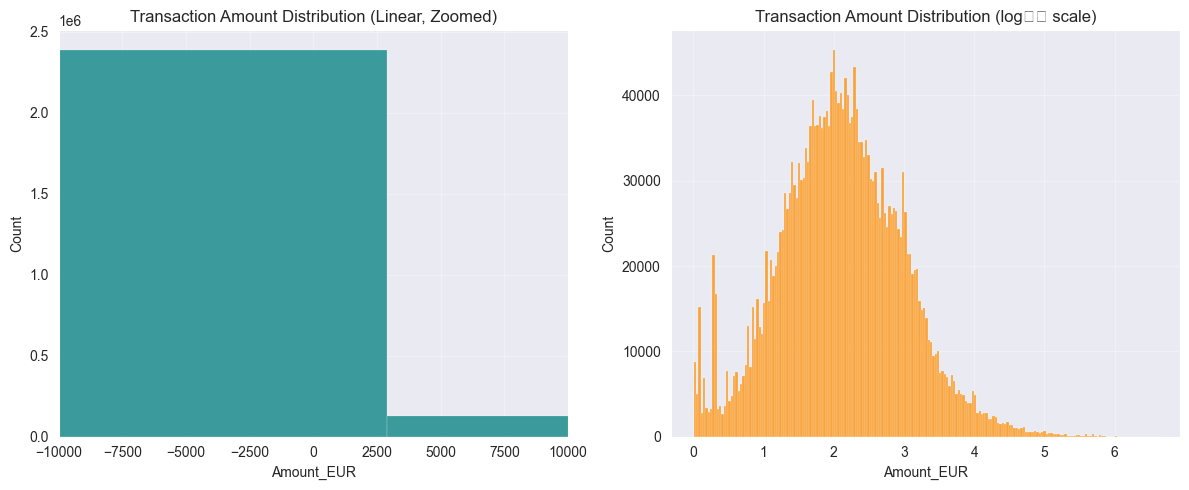

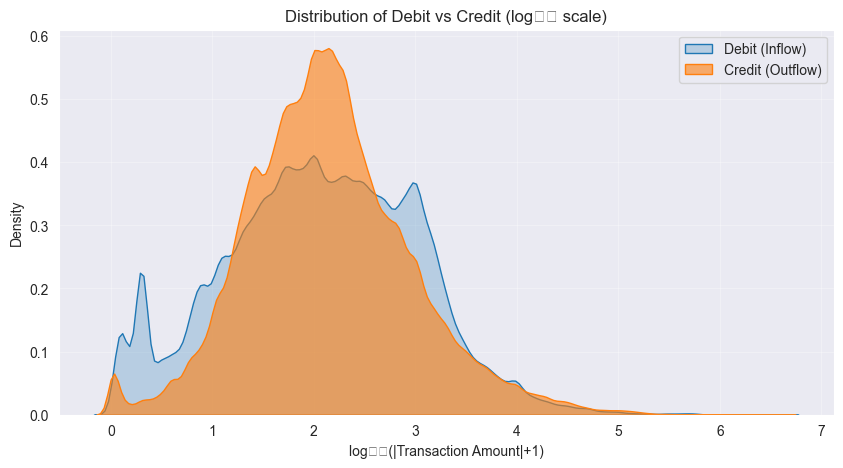

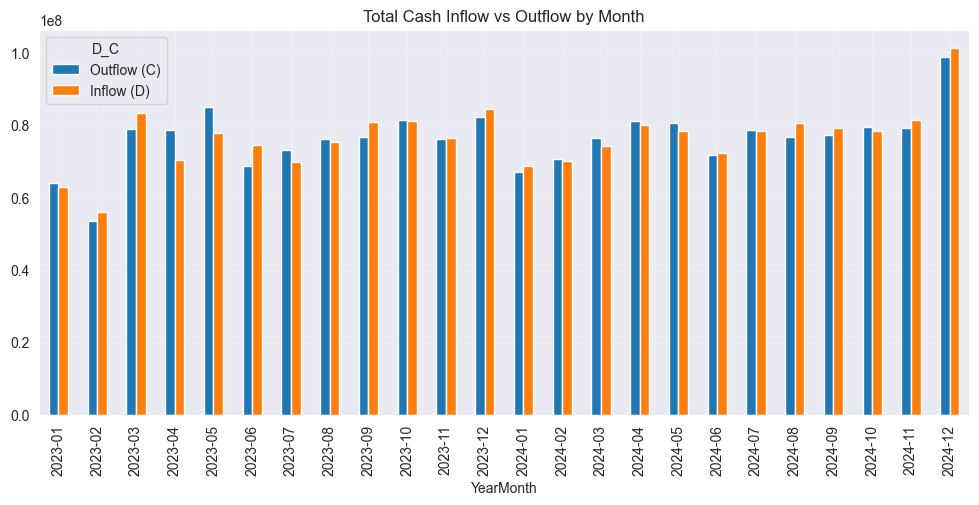

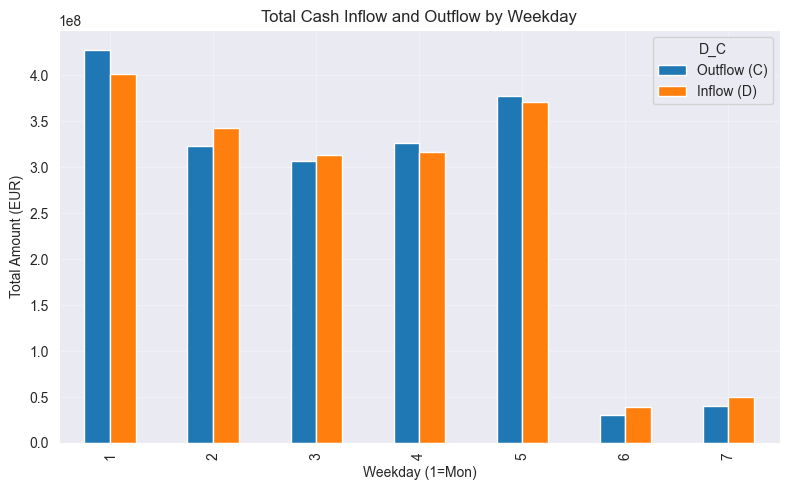

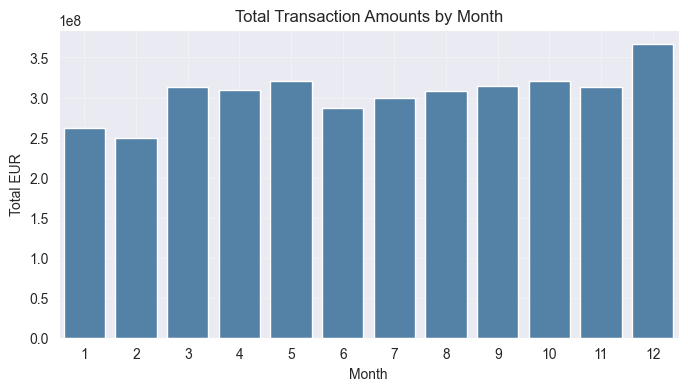

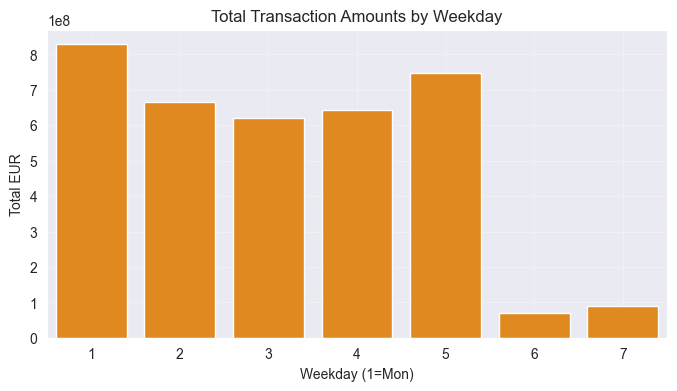

In [35]:
# ========================================
# 3. Exploratory Data Analysis
# ========================================

print("\n--- Descriptive Statistics for Transaction Amounts (EUR) ---")
desc = df['Amount_EUR'].describe().round(2)
print(desc)

print("\n--- Debit vs Credit Counts ---")
print(df['D_C'].value_counts())

print("\n--- Transactions per Customer ---")
tx_per_customer = df.groupby('cust_id')['Amount_EUR'].count()
print(tx_per_customer.describe().round(2))

print(f"\nSkewness: {skew(df['Amount_EUR']):.2f}, Kurtosis: {kurtosis(df['Amount_EUR']):.2f}")

# (a) Distribution plots (linear + log10 scale)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['Amount_EUR'], bins=200, color='teal')
plt.title('Transaction Amount Distribution (Linear, Zoomed)')
plt.xlim(-10000, 10000)
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
sns.histplot(np.log10(np.abs(df['Amount_EUR'])+1), bins=200, color='darkorange')
plt.title('Transaction Amount Distribution (log₁₀ scale)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# (b) Debit vs Credit log distribution
plt.figure(figsize=(10,5))
sns.kdeplot(np.log10(df[df['D_C']=='D']['Amount_EUR'].abs()+1), label='Debit (Inflow)', fill=True)
sns.kdeplot(np.log10(df[df['D_C']=='C']['Amount_EUR'].abs()+1), label='Credit (Outflow)', fill=True, alpha=0.6)
plt.title('Distribution of Debit vs Credit (log₁₀ scale)')
plt.xlabel('log₁₀(|Transaction Amount|+1)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# (c) Monthly inflows/outflows
df['YearMonth'] = df['BookingDatetime'].dt.to_period('M')
monthly_flows = df.groupby(['YearMonth', 'D_C'])['Amount_EUR'].sum().unstack(fill_value=0)
monthly_flows.rename(columns={'D':'Inflow (D)', 'C':'Outflow (C)'}).plot(kind='bar', figsize=(12,5))
plt.title('Total Cash Inflow vs Outflow by Month')
plt.grid(alpha=0.3)
plt.show()

# (d) Total Cash Inflow vs Outflow by Weekday
weekday_flows = df.groupby(['WeekDay', 'D_C'])['Amount_EUR'].sum().unstack(fill_value=0)
weekday_flows = weekday_flows.rename(columns={'D':'Inflow (D)', 'C':'Outflow (C)'})
weekday_flows.plot(kind='bar', figsize=(8,5))
plt.title('Total Cash Inflow and Outflow by Weekday')
plt.xlabel('Weekday (1=Mon)')
plt.ylabel('Total Amount (EUR)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# (e) Total Transaction Amounts by Month (All Transactions Combined)
monthly_totals = df.groupby('Month')['Amount_EUR'].sum()
plt.figure(figsize=(8,4))
sns.barplot(x=monthly_totals.index, y=monthly_totals.values, color='steelblue')
plt.title('Total Transaction Amounts by Month')
plt.xlabel('Month')
plt.ylabel('Total EUR')
plt.grid(alpha=0.3)
plt.show()

# (f) Total Transaction Amounts by Weekday
weekday_totals = df.groupby('WeekDay')['Amount_EUR'].sum()
plt.figure(figsize=(8,4))
sns.barplot(x=weekday_totals.index, y=weekday_totals.values, color='darkorange')
plt.title('Total Transaction Amounts by Weekday')
plt.xlabel('Weekday (1=Mon)')
plt.ylabel('Total EUR')
plt.grid(alpha=0.3)
plt.show()

In [36]:
# ========================================
# 4. Compute Daily Net Cash Flow per Customer
# ========================================

df['flow'] = df.apply(lambda x: x['Amount_EUR'] if x['D_C'] == 'D' else -x['Amount_EUR'], axis=1)

daily_cashflow = (
    df.groupby(['cust_id', pd.Grouper(key='BookingDatetime', freq='D')])['flow']
      .sum()
      .reset_index()
      .rename(columns={'flow': 'net_flow'})
)

print(f"Daily cashflow shape: {daily_cashflow.shape}")
print(daily_cashflow.head())
print(daily_cashflow.tail())

Daily cashflow shape: (270433, 3)
                                             cust_id BookingDatetime  net_flow
0  00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...      2023-01-01     -0.02
1  00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...      2023-01-08      2.00
2  00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...      2023-01-16    280.68
3  00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...      2023-01-17      0.40
4  00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...      2023-01-27     15.04
                                                  cust_id BookingDatetime  \
270428  ffbe5bd31c040dace3e025b7fc690b6f4bdc2a419b07e5...      2024-12-08   
270429  ffbe5bd31c040dace3e025b7fc690b6f4bdc2a419b07e5...      2024-12-16   
270430  ffbe5bd31c040dace3e025b7fc690b6f4bdc2a419b07e5...      2024-12-17   
270431  ffbe5bd31c040dace3e025b7fc690b6f4bdc2a419b07e5...      2024-12-18   
270432  ffbe5bd31c040dace3e025b7fc690b6f4bdc2a419b07e5...      2024-12-28   

        net_flow  
270428    

In [37]:
# ========================================
# 5. Winsorize Outliers (Top/Bottom 1%)
# ========================================

def winsorize_outliers(series, limits=(0.01, 0.01)):
    return pd.Series(winsorize(series, limits=limits), index=series.index)

daily_cashflow['net_flow_wins'] = (
    daily_cashflow.groupby('cust_id')['net_flow']
    .transform(lambda x: winsorize_outliers(x, limits=(0.01, 0.01)))
)

In [38]:
# ========================================
# 6. Filter and Analyze Customers with Adequate Transaction Size
# ========================================

def filter_adequate_customers(daily_cashflow, min_avg_flow, min_data_points):
    """
    Filter customers with adequate transaction size and data points
    """
    customer_stats = daily_cashflow.groupby('cust_id').agg({
        'net_flow_wins': ['count', 'mean', 'std', 'min', 'max']
    }).round(2)

    customer_stats.columns = ['count', 'mean', 'std', 'min', 'max']
    customer_stats = customer_stats.reset_index()

    # Filter criteria
    adequate_customers = customer_stats[
        (customer_stats['count'] >= min_data_points) &
        (np.abs(customer_stats['mean']) >= min_avg_flow) &
        (np.abs(customer_stats['max'] - customer_stats['min']) >= min_avg_flow * 2)
    ]

    print(f"\n Customer Filtering Results:")
    print(f"   Total customers: {len(customer_stats)}")
    print(f"   Adequate customers (flow > €{min_avg_flow}): {len(adequate_customers)}")
    print(f"   Excluded customers: {len(customer_stats) - len(adequate_customers)}")

    return adequate_customers['cust_id'].tolist(), customer_stats

# Filter adequate customers
adequate_customers_list, customer_stats_df = filter_adequate_customers(
    daily_cashflow, min_avg_flow=500, min_data_points=60)

# Use first adequate customer for example analysis
if adequate_customers_list:
    cust_example = adequate_customers_list[0]
    #print(f"\n Example Customer ID: {cust_example[:20]}...")
    print(f"\n Example Customer ID: {cust_example}...")

    df_cust = daily_cashflow[daily_cashflow['cust_id'] == cust_example].set_index('BookingDatetime')

    # Check statistics
    print(f"   Data points: {len(df_cust)}")
    print(f"   Average daily flow: €{df_cust['net_flow_wins'].mean():,.2f}")
    print(f"   Flow range: €{df_cust['net_flow_wins'].min():,.2f} to €{df_cust['net_flow_wins'].max():,.2f}")
else:
    print("No adequate customers found!")
    # Fall back to original customer
    cust_example = daily_cashflow['cust_id'].iloc[0]
    df_cust = daily_cashflow[daily_cashflow['cust_id'] == cust_example].set_index('BookingDatetime')


 Customer Filtering Results:
   Total customers: 958
   Adequate customers (flow > €500): 78
   Excluded customers: 880

 Example Customer ID: 04e1d3e843b1a9969233d3896cdca1fec3070efd4920502312a0707000c5dbc8...
   Data points: 103
   Average daily flow: €2,886.44
   Flow range: €-193,361.08 to €183,658.22


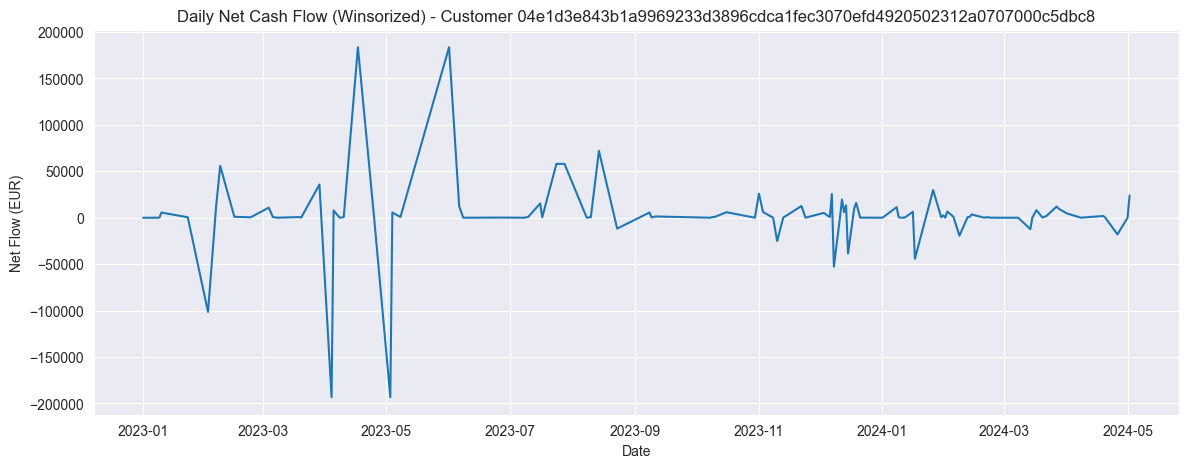

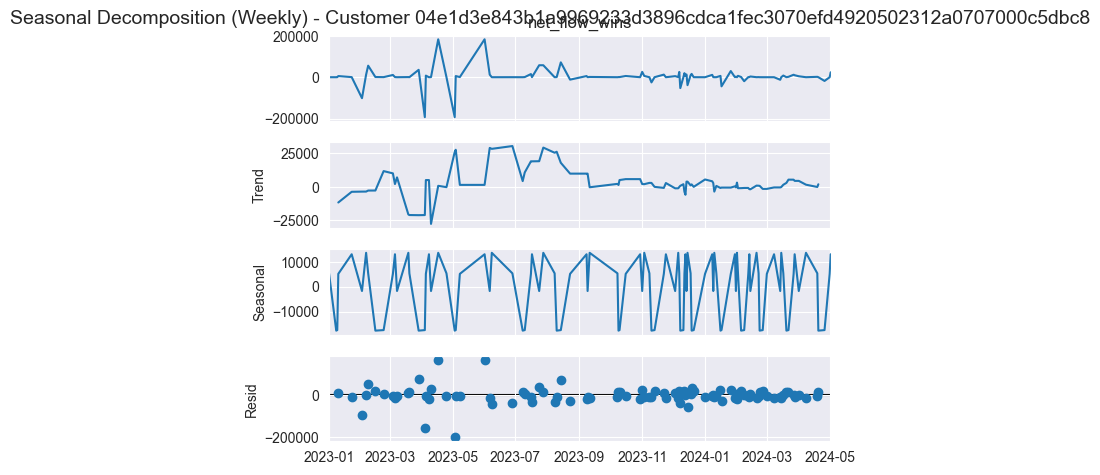

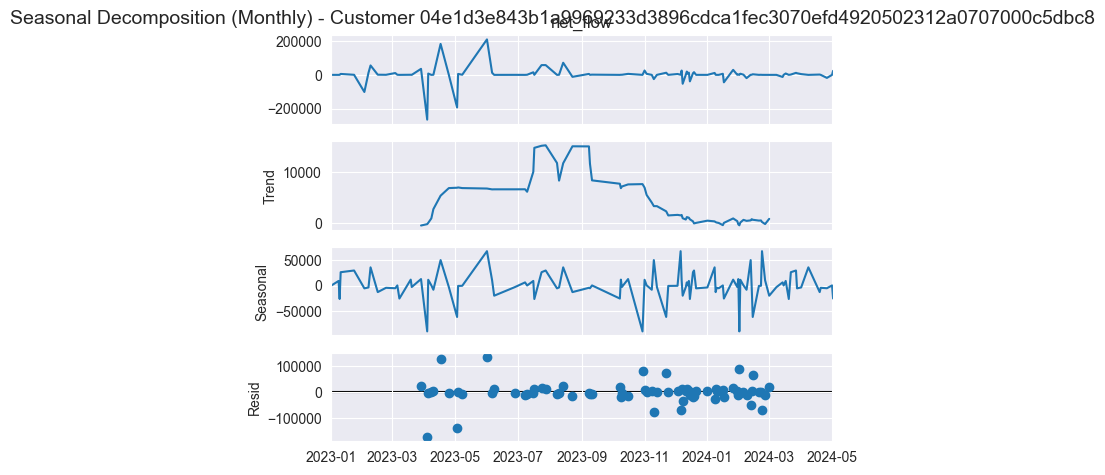

In [39]:
# ========================================
# 7. Analyze One Customer Example
# ========================================

plt.figure(figsize=(14,5))
plt.plot(df_cust['net_flow_wins'])
plt.title(f'Daily Net Cash Flow (Winsorized) - Customer {cust_example}')
plt.xlabel('Date')
plt.ylabel('Net Flow (EUR)')
plt.grid(True)
plt.show()

# Decomposition (Weekly)
result = seasonal_decompose(df_cust['net_flow_wins'].dropna(), model='additive', period=7)
result.plot()
plt.suptitle(f'Seasonal Decomposition (Weekly) - Customer {cust_example}', fontsize=14)
plt.show()

# Period=30 means monthly seasonality
result2 = seasonal_decompose(df_cust['net_flow'].dropna(), model='additive', period=30)
result2.plot()
plt.suptitle(f'Seasonal Decomposition (Monthly) - Customer {cust_example}', fontsize=14)
plt.show()

In [40]:
# ========================================
# 8. Stationarity (ADF Test)
# ========================================

def adf_test(series, name=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"\nADF Test for {name}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print("  Stationary ✅" if result[1] <= 0.05 else "  Non-stationary ❌")
    return result[1]

pval = adf_test(df_cust['net_flow_wins'], name=f"Customer {cust_example}")
if pval > 0.05:
    series_used = df_cust['net_flow_wins'].diff().dropna()
    print("➡ Differenced series used for modeling.")
else:
    series_used = df_cust['net_flow_wins']


ADF Test for Customer 04e1d3e843b1a9969233d3896cdca1fec3070efd4920502312a0707000c5dbc8:
  ADF Statistic: -8.4369
  p-value: 0.0000
  Stationary ✅


In [41]:
# ========================================
# 9. ARIMA Model Fitting
# ========================================

from statsmodels.tsa.arima.model import ARIMA
# Try simple ARIMA(1,0,1) as a starting point (we’ll tune later)
# d=0 means no differences, assuming stationary base series
model = ARIMA(df_cust['net_flow'], order=(1,0,1))
model_fit = model.fit()

print("\nModel Summary:")
print(model_fit.summary())


Model Summary:
                               SARIMAX Results                                
Dep. Variable:               net_flow   No. Observations:                  103
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1251.113
Date:                Sat, 13 Dec 2025   AIC                           2510.226
Time:                        19:25:21   BIC                           2520.765
Sample:                             0   HQIC                          2514.495
                                - 103                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2444.0769   3536.272      0.691      0.489   -4486.890    9375.044
ar.L1          0.5511      0.244      2.258      0.024       0.073       1.029
ma.L1         -0.7412      0.187    

In [42]:
# ========================================
# 10. SARIMA Grid Search
# ========================================

def sarima_grid_search(series, seasonal_period=7):
    best_aic = np.inf
    best_model = None
    best_params = None
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in pdq]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = SARIMAX(series, order=param, seasonal_order=param_seasonal,
                              enforce_stationarity=False, enforce_invertibility=False)
                res = mod.fit(disp=False)
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_model = res
                    best_params = (param, param_seasonal)
            except:
                continue
    return best_model, best_params, best_aic

best_model, best_params, best_aic = sarima_grid_search(series_used)
print(f"\n✅ Best SARIMA params: {best_params} | AIC: {best_aic:.2f}")


✅ Best SARIMA params: ((0, 1, 1), (0, 1, 1, 7)) | AIC: 2120.01


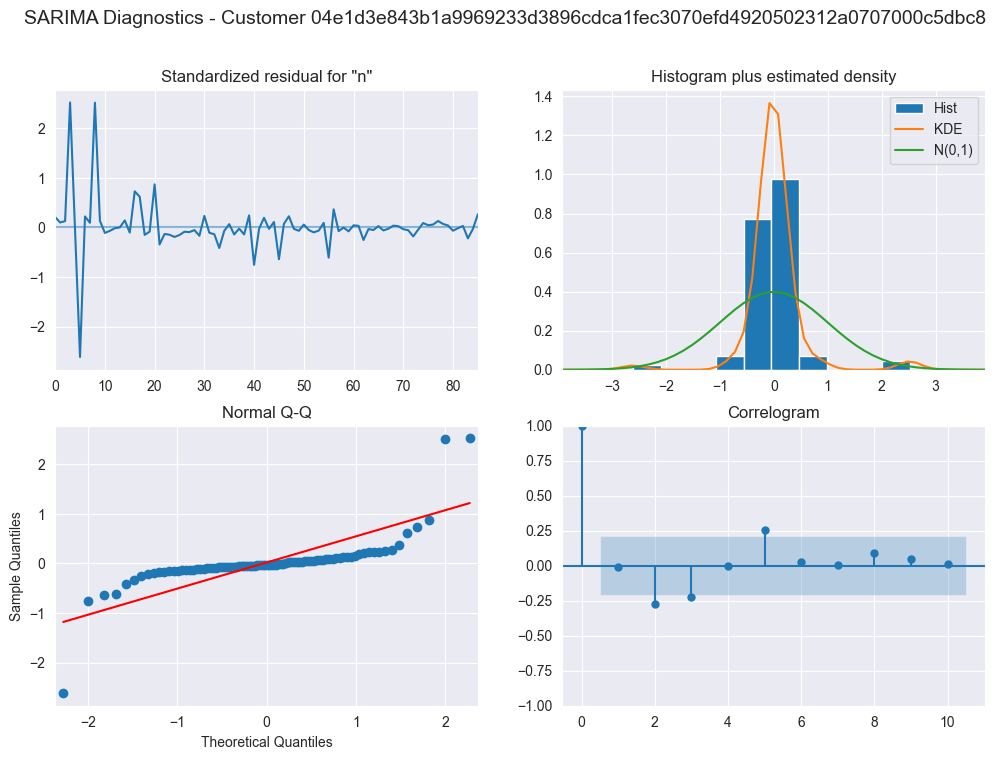

In [43]:
# ========================================
# 11. Model Diagnostics
# ========================================

best_model.plot_diagnostics(figsize=(12,8))
plt.suptitle(f"SARIMA Diagnostics - Customer {cust_example}", fontsize=14)
plt.show()


Model Performance on last 30 days:
  MAE = 6565.94
  RMSE = 9993.67


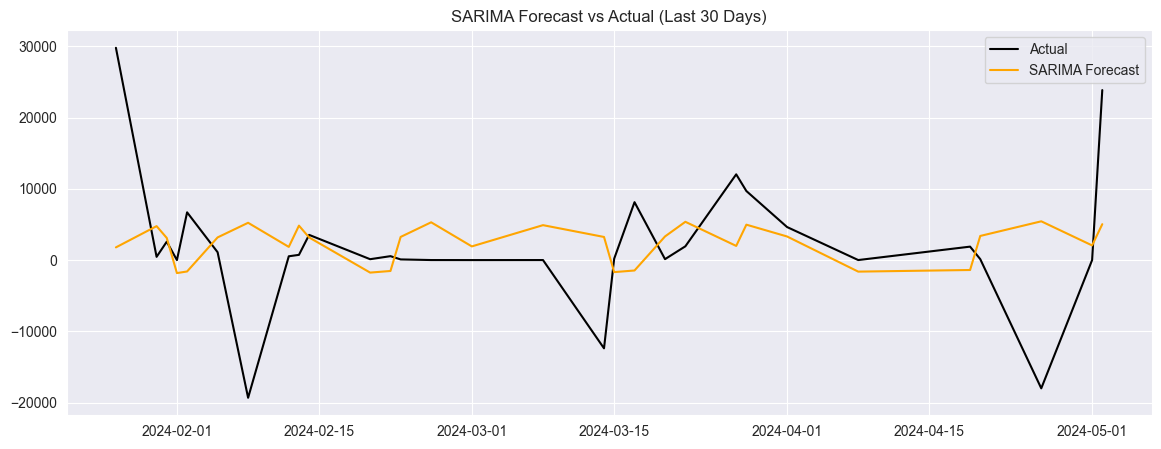

In [44]:
# ========================================
# 12. Train-Test Evaluation
# ========================================

train = series_used[:-30]
test = series_used[-30:]
forecast = best_model.forecast(steps=len(test))

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"\nModel Performance on last 30 days:\n  MAE = {mae:.2f}\n  RMSE = {rmse:.2f}")

plt.figure(figsize=(14,5))
plt.plot(test.index, test, label='Actual', color='black')
plt.plot(test.index, forecast, label='SARIMA Forecast', color='orange')
plt.title('SARIMA Forecast vs Actual (Last 30 Days)')
plt.legend()
plt.grid(True)
plt.show()

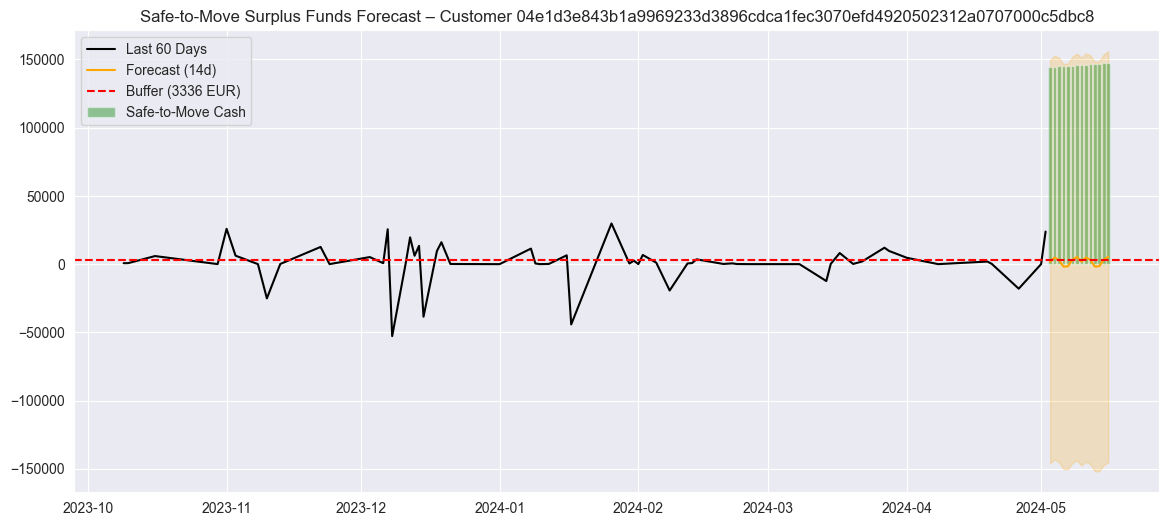


Overall Model Performance for Customer 04e1d3e843b1a9969233d3896cdca1fec3070efd4920502312a0707000c5dbc8:
  MAE: 6565.94
  RMSE: 9993.67
  Target met (RMSE ≤ 1000 EUR): False


In [45]:
# ========================================
# 13. Safe-to-Move Forecast
# ========================================

def calculate_safe_to_move(df_customer, sarima_model, forecast_horizon=14, liquidity_buffer_ratio=0.2):
    df_customer = df_customer.set_index('BookingDatetime').sort_index()
    avg_abs_flow = df_customer['net_flow_wins'].abs().mean()
    liquidity_buffer = liquidity_buffer_ratio * avg_abs_flow

    forecast = sarima_model.get_forecast(steps=forecast_horizon)
    forecast_df = forecast.conf_int()
    forecast_df['Forecast'] = forecast.predicted_mean
    forecast_df.index = pd.date_range(df_customer.index[-1], periods=forecast_horizon+1, freq='D')[1:]

    forecast_df['Safe_to_Move'] = np.maximum(forecast_df['Forecast'] - liquidity_buffer - forecast_df.iloc[:,0], 0)
    return forecast_df, liquidity_buffer

forecast_df, liquidity_buffer = calculate_safe_to_move(df_cust.reset_index(), best_model, 14, 0.2)

plt.figure(figsize=(14,6))
plt.plot(df_cust.index[-60:], df_cust['net_flow_wins'].iloc[-60:], color='black', label='Last 60 Days')
plt.plot(forecast_df.index, forecast_df['Forecast'], color='orange', label='Forecast (14d)')
plt.fill_between(forecast_df.index, forecast_df.iloc[:,0], forecast_df.iloc[:,1], color='orange', alpha=0.2)
plt.bar(forecast_df.index, forecast_df['Safe_to_Move'], alpha=0.4, color='green', label='Safe-to-Move Cash')
plt.axhline(y=liquidity_buffer, color='red', linestyle='--', label=f'Buffer ({liquidity_buffer:.0f} EUR)')
plt.title(f"Safe-to-Move Surplus Funds Forecast – Customer {cust_example}")
plt.legend()
plt.grid(True)
plt.show()

print(f"\nOverall Model Performance for Customer {cust_example}:")
print(f"  MAE: {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  Target met (RMSE ≤ 1000 EUR): {rmse <= 1000}")

In [46]:
# ========================================
# 14. Automated Analysis with Grid Search
# ========================================

def analyze_customer_with_grid_search(cust_id, cashflow_data,
                                      forecast_days=7, test_days=7,
                                      buffer_days=3, min_daily_balance=1000):
    """
    Full analysis with grid search for each customer
    """
    try:
        # Get customer data
        df_cust = cashflow_data[cashflow_data['cust_id'] == cust_id].copy()
        if len(df_cust) < 60:  # Need minimum data points
            return None

        df_cust = df_cust.set_index('BookingDatetime').sort_index()

        # Prepare series
        series = df_cust['net_flow_wins'].dropna()
        if len(series) < 60:
            return None

        # Check if customer has adequate transaction size
        avg_flow = series.mean()
        flow_range = series.max() - series.min()
        if abs(avg_flow) < 500 or flow_range < 1000:  # Lower threshold for testing
            return None

        # Train-test split (last test_days for validation)
        train = series[:-test_days]
        test = series[-test_days:]

        try:
            # Use grid search to find best SARIMA parameters
            print(f"\n🔍 Grid search for customer {cust_id[:15]}...")
            best_model, best_params, best_aic = sarima_grid_search(train)

            if best_model is None:
                print(f"  No suitable model found")
                return None

            print(f"  Best params: {best_params}, AIC: {best_aic:.2f}")

            # Forecast on test set
            forecast = best_model.forecast(steps=len(test))

            # Calculate metrics
            mae = mean_absolute_error(test, forecast)
            rmse = np.sqrt(mean_squared_error(test, forecast))

            # Realistic safe-to-move calculation
            historical_flows = series
            avg_daily_flow = historical_flows.mean()
            std_daily_flow = historical_flows.std()

            # Calculate current balance (simplified as cumulative sum)
            current_balance = historical_flows.cumsum().iloc[-1] if len(historical_flows) > 0 else 0

            # Conservative buffer
            avg_outflow = historical_flows[historical_flows < 0].mean() if len(historical_flows[historical_flows < 0]) > 0 else 0
            buffer = abs(avg_outflow) * buffer_days * 1.5
            buffer = max(buffer, min_daily_balance)

            # Get forecast with confidence interval
            forecast_full = best_model.get_forecast(steps=forecast_days)
            forecast_df = forecast_full.conf_int(alpha=0.2)  # 80% CI
            forecast_df['Forecast'] = forecast_full.predicted_mean
            forecast_df.index = pd.date_range(series.index[-1], periods=forecast_days+1, freq='D')[1:]

            # Calculate cumulative forecast
            forecast_df['Cumulative_Forecast'] = forecast_df['Forecast'].cumsum()
            forecast_df['Lower_Bound_Cumulative'] = forecast_df.iloc[:, 0].cumsum()

            # Calculate safe-to-move
            forecast_df['Projected_Balance'] = current_balance + forecast_df['Cumulative_Forecast']
            forecast_df['Safe_to_Move'] = np.maximum(
                forecast_df['Projected_Balance'] - buffer - forecast_df['Lower_Bound_Cumulative'],
                0)

            # Cap at reasonable percentage
            max_safe_percentage = 0.7
            max_safe_absolute = abs(current_balance) * max_safe_percentage if current_balance > 0 else 0
            forecast_df['Safe_to_Move'] = forecast_df['Safe_to_Move'].clip(upper=max_safe_absolute)

            total_safe_to_move = forecast_df['Safe_to_Move'].sum()

            # Calculate transfer suggestion validity
            valid_days = (forecast_df['Safe_to_Move'] > 0).sum()
            transfer_validity_rate = valid_days / forecast_days if forecast_days > 0 else 0

            return {
                'cust_id': cust_id,
                'mae': mae,
                'rmse': rmse,
                'avg_daily_flow': avg_daily_flow,
                'std_daily_flow': std_daily_flow,
                'current_balance_est': current_balance,
                'buffer': buffer,
                'total_safe_to_move': total_safe_to_move,
                'transfer_validity_rate': transfer_validity_rate,
                'data_points': len(series),
                'sarima_params': best_params,
                'aic': best_aic,
                'meets_accuracy_target': rmse <= 1000,
                'meets_safety_target': True,
                'forecast_df': forecast_df,
                'best_model': best_model
            }

        except Exception as e:
            print(f"  Model fitting failed: {str(e)[:100]}")
            return None

    except Exception as e:
        print(f"Analysis failed: {str(e)[:100]}")
        return None

# Run analysis with grid search
print("Starting analysis with grid search for all customers...")
results_corrected_grid = []

# Use adequate customers from smart filter or first N customers
if 'adequate_customers_list' in locals() and len(adequate_customers_list) > 0:
    customers_to_analyze = adequate_customers_list[:len(adequate_customers_list)]  # All adequate_customers
else:
    # Fallback: first 20 customers with enough data
    customer_counts = daily_cashflow.groupby('cust_id').size()
    customers_to_analyze = customer_counts[customer_counts >= 60].index[:20].tolist()

print(f"Analyzing {len(customers_to_analyze)} customers...")

for i, cust_id in enumerate(customers_to_analyze):
    print(f"\n[{i+1}/{len(customers_to_analyze)}] Customer: {cust_id[:15]}...")

    result = analyze_customer_with_grid_search(cust_id, daily_cashflow,
                                              forecast_days=7, test_days=7)
    if result is not None:
        results_corrected_grid.append(result)
        print(f"  RMSE: €{result['rmse']:.2f}, Safe-to-Move: €{result['total_safe_to_move']:.2f}")

print(f"\n✅ Completed analysis for {len(results_corrected_grid)} customers")

Starting analysis with grid search for all customers...
Analyzing 78 customers...

[1/78] Customer: 04e1d3e843b1a99...

🔍 Grid search for customer 04e1d3e843b1a99...
  Best params: ((0, 1, 1), (0, 1, 1, 7)), AIC: 1954.03
  RMSE: €10137.30, Safe-to-Move: €1446704.68

[2/78] Customer: 053c270b181ec97...

🔍 Grid search for customer 053c270b181ec97...
  Best params: ((0, 0, 0), (0, 1, 1, 7)), AIC: 10708.64
  RMSE: €2583.76, Safe-to-Move: €0.00

[3/78] Customer: 0766bb3f1b436e2...

🔍 Grid search for customer 0766bb3f1b436e2...
  Best params: ((0, 0, 0), (0, 1, 1, 7)), AIC: 17035.72
  RMSE: €27449.66, Safe-to-Move: €5814728.47

[4/78] Customer: 0e93dec39644e7a...

🔍 Grid search for customer 0e93dec39644e7a...
  Best params: ((0, 0, 0), (1, 1, 1, 7)), AIC: 14349.59
  RMSE: €13942.02, Safe-to-Move: €0.00

[5/78] Customer: 0f318fa315b2b50...

🔍 Grid search for customer 0f318fa315b2b50...
  Best params: ((1, 0, 1), (1, 1, 1, 7)), AIC: 3191.30
  RMSE: €42318.49, Safe-to-Move: €926027.48

[6/78] C


OVERALL RESULTS SUMMARY (with Grid Search)

 Total Customers Analyzed: 78
 Customers Meeting Accuracy Target (RMSE ≤ 1000): 4
 Accuracy Target Success Rate: 5.1%

 Performance Metrics Summary:
   Average MAE: €29041.09
   Average RMSE: €45531.36
   Best RMSE: €441.56
   Worst RMSE: €607089.30

 Safe-to-Move Funds Analysis:
   Total Identified Surplus: €189,782,275.98
   Average per Customer: €2,433,106.10
   Maximum per Customer: €21,877,553.81

✅ Transfer Suggestions Validity:
   Average validity rate: 72.9%
   Customers with >50% validity: 57


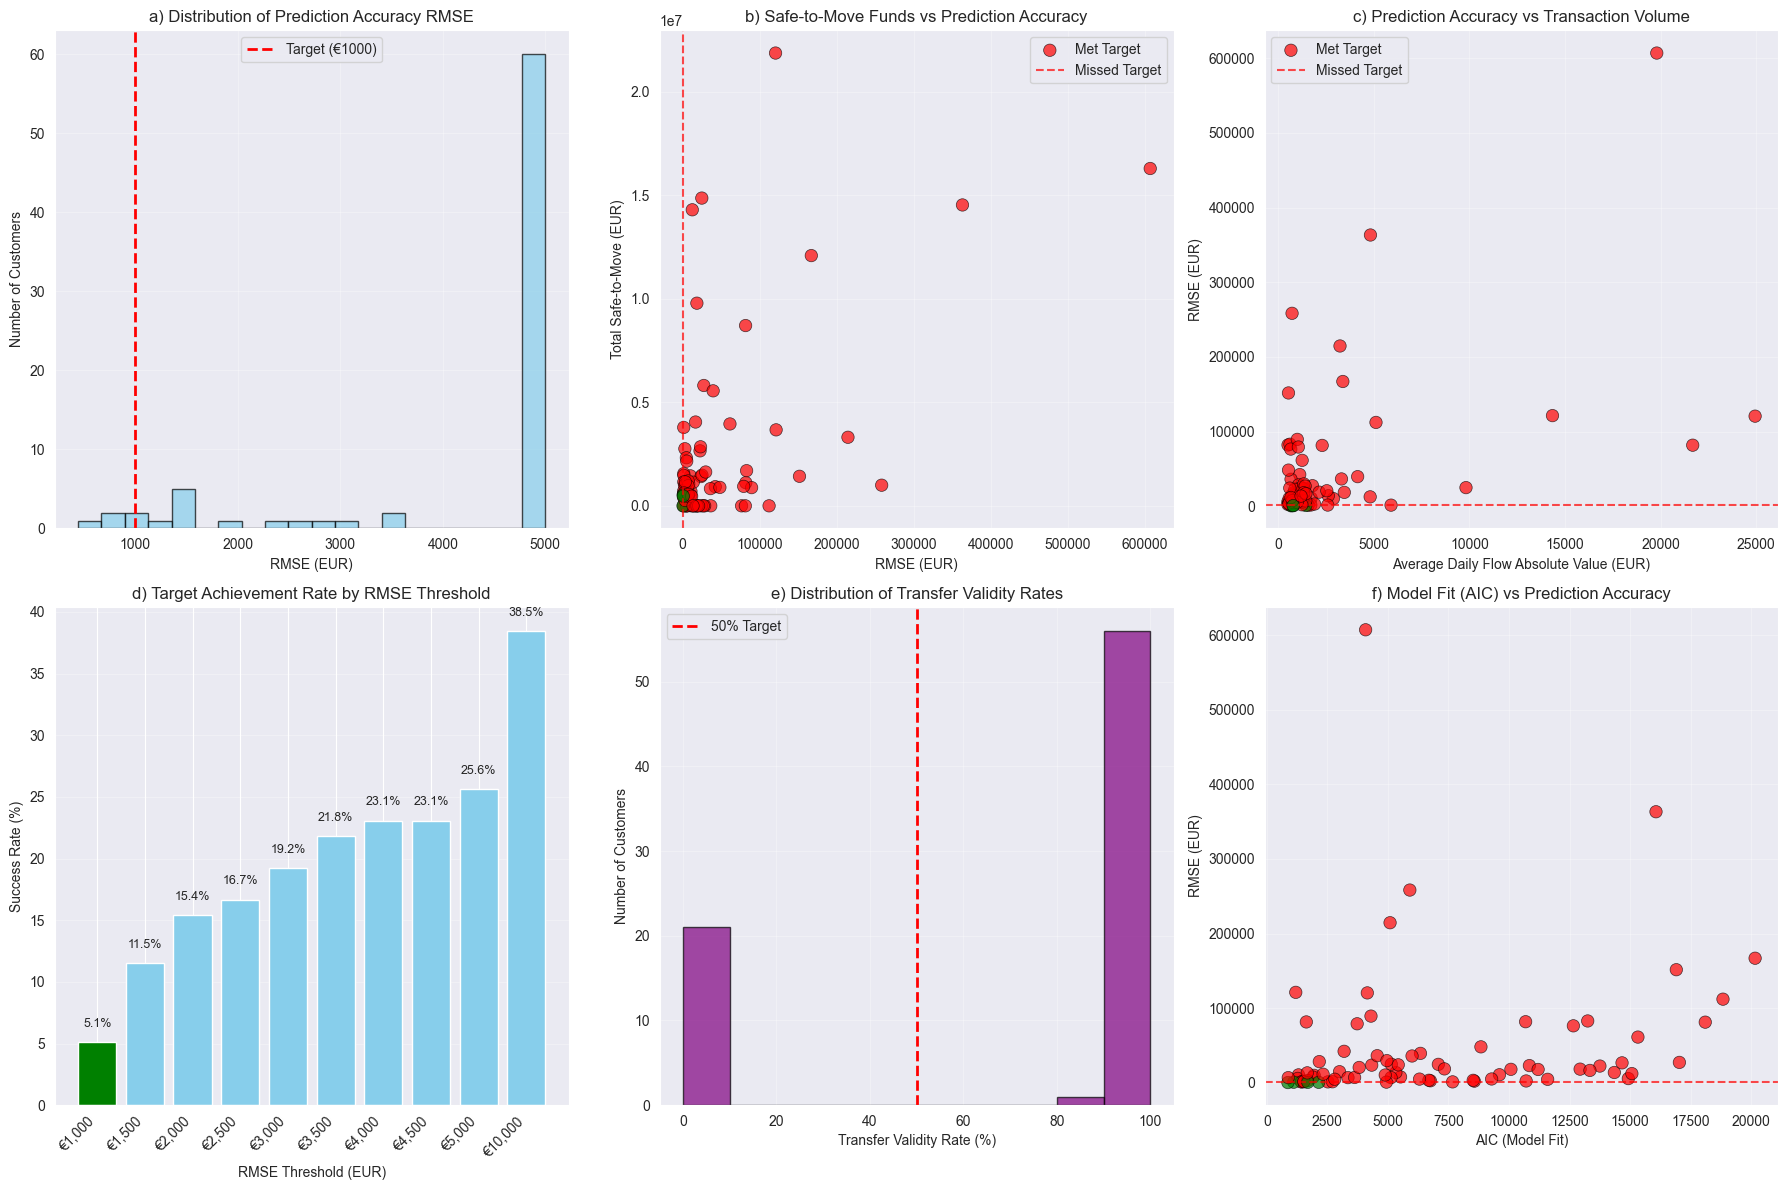

In [48]:
# ========================================
# 15. Visualization of Overall Results
# ========================================

if len(results_corrected_grid) > 0:
    results_df = pd.DataFrame(results_corrected_grid)

    print("\n" + "="*60)
    print("OVERALL RESULTS SUMMARY (with Grid Search)")
    print("="*60)

    # Basic statistics
    print(f"\n Total Customers Analyzed: {len(results_df)}")
    print(f" Customers Meeting Accuracy Target (RMSE ≤ 1000): {results_df['meets_accuracy_target'].sum()}")
    print(f" Accuracy Target Success Rate: {results_df['meets_accuracy_target'].mean()*100:.1f}%")

    # Performance metrics summary
    print(f"\n Performance Metrics Summary:")
    print(f"   Average MAE: €{results_df['mae'].mean():.2f}")
    print(f"   Average RMSE: €{results_df['rmse'].mean():.2f}")
    print(f"   Best RMSE: €{results_df['rmse'].min():.2f}")
    print(f"   Worst RMSE: €{results_df['rmse'].max():.2f}")

    # Safe-to-move analysis
    print(f"\n Safe-to-Move Funds Analysis:")
    print(f"   Total Identified Surplus: €{results_df['total_safe_to_move'].sum():,.2f}")
    print(f"   Average per Customer: €{results_df['total_safe_to_move'].mean():,.2f}")
    print(f"   Maximum per Customer: €{results_df['total_safe_to_move'].max():,.2f}")

    # Transfer validity
    print(f"\n✅ Transfer Suggestions Validity:")
    print(f"   Average validity rate: {results_df['transfer_validity_rate'].mean()*100:.1f}%")
    print(f"   Customers with >50% validity: {(results_df['transfer_validity_rate'] > 0.5).sum()}")

    # Create subplots for visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Distribution of RMSE
    axes[0,0].hist(results_df['rmse'].clip(upper=5000), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].axvline(x=1000, color='red', linestyle='--', linewidth=2, label='Target (€1000)')
    axes[0,0].set_xlabel('RMSE (EUR)')
    axes[0,0].set_ylabel('Number of Customers')
    axes[0,0].set_title('a) Distribution of Prediction Accuracy RMSE')
    axes[0,0].legend()
    axes[0,0].grid(alpha=0.3)

    # 2. Safe-to-Move vs RMSE
    scatter = axes[0,1].scatter(results_df['rmse'], results_df['total_safe_to_move'],
                               c=results_df['meets_accuracy_target'].map({True:'green', False:'red'}),
                               alpha=0.7, s=80, edgecolors='black', linewidth=0.5)
    axes[0,1].axvline(x=1000, color='red', linestyle='--', alpha=0.7, label='RMSE Target')
    axes[0,1].set_xlabel('RMSE (EUR)')
    axes[0,1].set_ylabel('Total Safe-to-Move (EUR)')
    axes[0,1].set_title('b) Safe-to-Move Funds vs Prediction Accuracy')
    axes[0,1].legend(['Met Target', 'Missed Target', 'RMSE Threshold'])
    axes[0,1].grid(alpha=0.3)

    # 3. RMSE vs Average Daily Flow (absolute)
    axes[0,2].scatter(results_df['avg_daily_flow'].abs(), results_df['rmse'],
                     c=results_df['meets_accuracy_target'].map({True:'green', False:'red'}),
                     alpha=0.7, s=80, edgecolors='black', linewidth=0.5)
    axes[0,2].axhline(y=1000, color='red', linestyle='--', alpha=0.7, label='RMSE Target')
    axes[0,2].set_xlabel('Average Daily Flow Absolute Value (EUR)')
    axes[0,2].set_ylabel('RMSE (EUR)')
    axes[0,2].set_title('c) Prediction Accuracy vs Transaction Volume')
    axes[0,2].legend(['Met Target', 'Missed Target', 'RMSE Threshold'])
    axes[0,2].grid(alpha=0.3)

    # 4. Target Achievement for different thresholds
    thresholds = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 10000]
    success_rates = []
    for threshold in thresholds:
        success_rate = (results_df['rmse'] <= threshold).mean() * 100
        success_rates.append(success_rate)

    bars = axes[1,0].bar(range(len(thresholds)), success_rates,
                        color=['green' if threshold == 1000 else 'skyblue' for threshold in thresholds])
    axes[1,0].set_xticks(range(len(thresholds)))
    axes[1,0].set_xticklabels([f'€{t:,}' for t in thresholds], rotation=45, ha='right')
    axes[1,0].set_xlabel('RMSE Threshold (EUR)')
    axes[1,0].set_ylabel('Success Rate (%)')
    axes[1,0].set_title('d) Target Achievement Rate by RMSE Threshold')
    axes[1,0].grid(alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, rate in zip(bars, success_rates):
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 1,
                      f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)

    # 5. Distribution of Transfer Validity Rate
    axes[1,1].hist(results_df['transfer_validity_rate'] * 100, bins=10,
                  alpha=0.7, color='purple', edgecolor='black')
    axes[1,1].axvline(x=50, color='red', linestyle='--', linewidth=2, label='50% Target')
    axes[1,1].set_xlabel('Transfer Validity Rate (%)')
    axes[1,1].set_ylabel('Number of Customers')
    axes[1,1].set_title('e) Distribution of Transfer Validity Rates')
    axes[1,1].legend()
    axes[1,1].grid(alpha=0.3)

    # 6. RMSE vs SARIMA Model Complexity (AIC)
    if 'aic' in results_df.columns:
        axes[1,2].scatter(results_df['aic'], results_df['rmse'],
                         c=results_df['meets_accuracy_target'].map({True:'green', False:'red'}),
                         alpha=0.7, s=80, edgecolors='black', linewidth=0.5)
        axes[1,2].axhline(y=1000, color='red', linestyle='--', alpha=0.7)
        axes[1,2].set_xlabel('AIC (Model Fit)')
        axes[1,2].set_ylabel('RMSE (EUR)')
        axes[1,2].set_title('f) Model Fit (AIC) vs Prediction Accuracy')
        axes[1,2].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [50]:
# ========================================
# 16. Detailed Analysis of Successful Customers
# ========================================

if len(results_corrected_grid) > 0:
    results_df = pd.DataFrame(results_corrected_grid)
    successful_customers = results_df[results_df['meets_accuracy_target']]
    unsuccessful_customers = results_df[~results_df['meets_accuracy_target']]

    print(f"\n{'='*60}")
    print("DETAILED ANALYSIS OF SUCCESSFUL CUSTOMERS")
    print(f"{'='*60}")

    print(f"\n✅ SUCCESSFUL CUSTOMERS (RMSE ≤ 1000): {len(successful_customers)}")
    if len(successful_customers) > 0:
        print(f"   Average RMSE: €{successful_customers['rmse'].mean():.2f}")
        print(f"   Average MAE: €{successful_customers['mae'].mean():.2f}")
        print(f"   Total Safe-to-Move: €{successful_customers['total_safe_to_move'].sum():,.2f}")
        print(f"   Average Daily Flow: €{successful_customers['avg_daily_flow'].mean():.2f}")
        print(f"   Average Buffer: €{successful_customers['buffer'].mean():.2f}")
        print(f"   Average Transfer Validity: {successful_customers['transfer_validity_rate'].mean()*100:.1f}%")

        # Print individual successful customers
        print(f"\n DETAILS OF SUCCESSFUL CUSTOMERS:")
        for idx, row in successful_customers.iterrows():
            print(f"\n   Customer: {row['cust_id'][:15]}...")
            print(f"     RMSE: €{row['rmse']:.2f}")
            print(f"     MAE: €{row['mae']:.2f}")
            print(f"     Avg Daily Flow: €{row['avg_daily_flow']:.2f}")
            print(f"     Safe-to-Move (7-day): €{row['total_safe_to_move']:.2f}")
            print(f"     Transfer Validity: {row['transfer_validity_rate']*100:.0f}%")
            print(f"     SARIMA params: {row['sarima_params']}")
            if 'aic' in row:
                print(f"     AIC: {row['aic']:.2f}")

    print(f"\n❌ UNSUCCESSFUL CUSTOMERS (RMSE > 1000): {len(unsuccessful_customers)}")
    if len(unsuccessful_customers) > 0:
        print(f"   Average RMSE: €{unsuccessful_customers['rmse'].mean():.2f}")
        print(f"   Average MAE: €{unsuccessful_customers['mae'].mean():.2f}")
        print(f"   Total Safe-to-Move: €{unsuccessful_customers['total_safe_to_move'].sum():,.2f}")
        print(f"   Average Daily Flow: €{unsuccessful_customers['avg_daily_flow'].mean():.2f}")

        # Print top 5 worst performers
        print(f"\n⚠️  TOP 5 WORST PERFORMERS:")
        worst_customers = unsuccessful_customers.nlargest(5, 'rmse')
        for idx, row in worst_customers.iterrows():
            print(f"   Customer {row['cust_id'][:15]}...: RMSE €{row['rmse']:.2f}, Flow €{row['avg_daily_flow']:.2f}")


DETAILED ANALYSIS OF SUCCESSFUL CUSTOMERS

✅ SUCCESSFUL CUSTOMERS (RMSE ≤ 1000): 4
   Average RMSE: €722.55
   Average MAE: €584.72
   Total Safe-to-Move: €1,552,055.60
   Average Daily Flow: €583.46
   Average Buffer: €7101.00
   Average Transfer Validity: 75.0%

 DETAILS OF SUCCESSFUL CUSTOMERS:

   Customer: 54c5bbd5b020fe2...
     RMSE: €917.60
     MAE: €692.29
     Avg Daily Flow: €1444.93
     Safe-to-Move (7-day): €559330.79
     Transfer Validity: 100%
     SARIMA params: ((0, 0, 1), (1, 1, 1, 7))
     AIC: 1109.85

   Customer: ab27fe1d10bbc3e...
     RMSE: €441.56
     MAE: €409.12
     Avg Daily Flow: €-681.39
     Safe-to-Move (7-day): €0.00
     Transfer Validity: 0%
     SARIMA params: ((0, 1, 1), (0, 1, 1, 7))
     AIC: 870.15

   Customer: d2a9d46443e64cc...
     RMSE: €770.32
     MAE: €602.60
     Avg Daily Flow: €787.25
     Safe-to-Move (7-day): €524626.24
     Transfer Validity: 100%
     SARIMA params: ((1, 0, 1), (1, 1, 1, 7))
     AIC: 2140.75

   Customer: fe

In [51]:
# ========================================
# 17. Export Results for Dashboard
# ========================================

if len(results_corrected_grid) > 0:
    results_df = pd.DataFrame(results_corrected_grid)

    # Prepare data for dashboard
    dashboard_data = results_df[['cust_id', 'mae', 'rmse', 'total_safe_to_move',
                               'avg_daily_flow', 'transfer_validity_rate',
                               'meets_accuracy_target']].copy()

    # Add performance categories
    def categorize_performance(row):
        if row['rmse'] <= 500:
            return 'Excellent'
        elif row['rmse'] <= 1000:
            return 'Good'
        elif row['rmse'] <= 2000:
            return 'Fair'
        else:
            return 'Poor'

    dashboard_data['performance_category'] = dashboard_data.apply(categorize_performance, axis=1)

    # Add transfer recommendation
    def transfer_recommendation(row):
        if row['meets_accuracy_target'] and row['transfer_validity_rate'] > 0.5:
            return 'Strong Recommend'
        elif row['meets_accuracy_target']:
            return 'Recommend with Caution'
        elif row['total_safe_to_move'] > 0:
            return 'Limited Recommendation'
        else:
            return 'Not Recommended'

    dashboard_data['transfer_recommendation'] = dashboard_data.apply(transfer_recommendation, axis=1)

    # Export to CSV
    from datetime import datetime

    # Create timestamp for unique filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save in Google Drive
    export_path = f'C:/Users/avolz/PycharmProjects/ML_SEB_local/Data/sme_cashflow_analysis_{timestamp}.csv'
    dashboard_data.to_csv(export_path, index=False)

    print(f"\n💾 Results exported to: {export_path}")
    print(f"📁 File contains analysis for {len(dashboard_data)} customers")


💾 Results exported to: C:/Users/avolz/PycharmProjects/ML_SEB_local/Data/sme_cashflow_analysis_20251213_194042.csv
📁 File contains analysis for 78 customers


In [54]:
# ========================================
# 18. Final Summary Report
# ========================================

if len(results_corrected_grid) > 0:
    results_df = pd.DataFrame(results_corrected_grid)
    successful_customers = results_df[results_df['meets_accuracy_target']]

    # Create dashboard_data if not already created
    if 'dashboard_data' not in locals():
        dashboard_data = results_df[['cust_id', 'mae', 'rmse', 'total_safe_to_move',
                                   'avg_daily_flow', 'transfer_validity_rate',
                                   'meets_accuracy_target']].copy()

    print(f"\n{'='*70}")
    print("FINAL PROJECT SUMMARY REPORT")
    print(f"{'='*70}")

    print(f"\n PROJECT OBJECTIVES STATUS:")
    print(f"   1. Predict cash flow needs (RMSE ≤ €1000): {results_df['meets_accuracy_target'].mean()*100:.1f}% success rate")
    print(f"   2. Identify safe-to-move surplus: €{results_df['total_safe_to_move'].sum():,.2f} total identified")
    print(f"   3. Transfer suggestions: {(results_df['transfer_validity_rate'] > 0.5).mean()*100:.1f}% meet >50% validity")
    print(f"   4. Dashboard data: Ready for {len(dashboard_data)} customers")

    print(f"\n KEY INSIGHTS:")
    print(f"   • {len(successful_customers)} customers can be accurately predicted (RMSE ≤ €1000)")
    print(f"   • Total surplus funds identified: €{results_df['total_safe_to_move'].sum():,.2f}")
    print(f"   • Average prediction error: €{results_df['rmse'].mean():.2f} RMSE")
    print(f"   • Best prediction accuracy: €{results_df['rmse'].min():.2f} RMSE")

    print(f"\n RECOMMENDATIONS:")
    print(f"   1. Focus on {len(successful_customers)} predictable customers first")
    print(f"   2. Implement automated transfers for customers with high safe-to-move funds")
    print(f"   3. Use different thresholds based on customer risk profile")
    print(f"   4. Regularly update models with new transaction data")

    print(f"\n📊 DASHBOARD READY:")
    print(f"   • Performance categories: Excellent/Good/Fair/Poor")
    print(f"   • Transfer recommendations: Strong/Limited/Caution/Not Recommended")
    print(f"   • Key metrics: RMSE, MAE, Safe-to-Move, Transfer Validity")
    print(f"   • Target achievement tracking")

    print(f"\n✅ PROJECT ANALYSIS COMPLETE!")
else:
    print("No results to analyze!")


FINAL PROJECT SUMMARY REPORT

 PROJECT OBJECTIVES STATUS:
   1. Predict cash flow needs (RMSE ≤ €1000): 5.1% success rate
   2. Identify safe-to-move surplus: €189,782,275.98 total identified
   3. Transfer suggestions: 73.1% meet >50% validity
   4. Dashboard data: Ready for 78 customers

 KEY INSIGHTS:
   • 4 customers can be accurately predicted (RMSE ≤ €1000)
   • Total surplus funds identified: €189,782,275.98
   • Average prediction error: €45531.36 RMSE
   • Best prediction accuracy: €441.56 RMSE

 RECOMMENDATIONS:
   1. Focus on 4 predictable customers first
   2. Implement automated transfers for customers with high safe-to-move funds
   3. Use different thresholds based on customer risk profile
   4. Regularly update models with new transaction data

📊 DASHBOARD READY:
   • Performance categories: Excellent/Good/Fair/Poor
   • Transfer recommendations: Strong/Limited/Caution/Not Recommended
   • Key metrics: RMSE, MAE, Safe-to-Move, Transfer Validity
   • Target achievement 

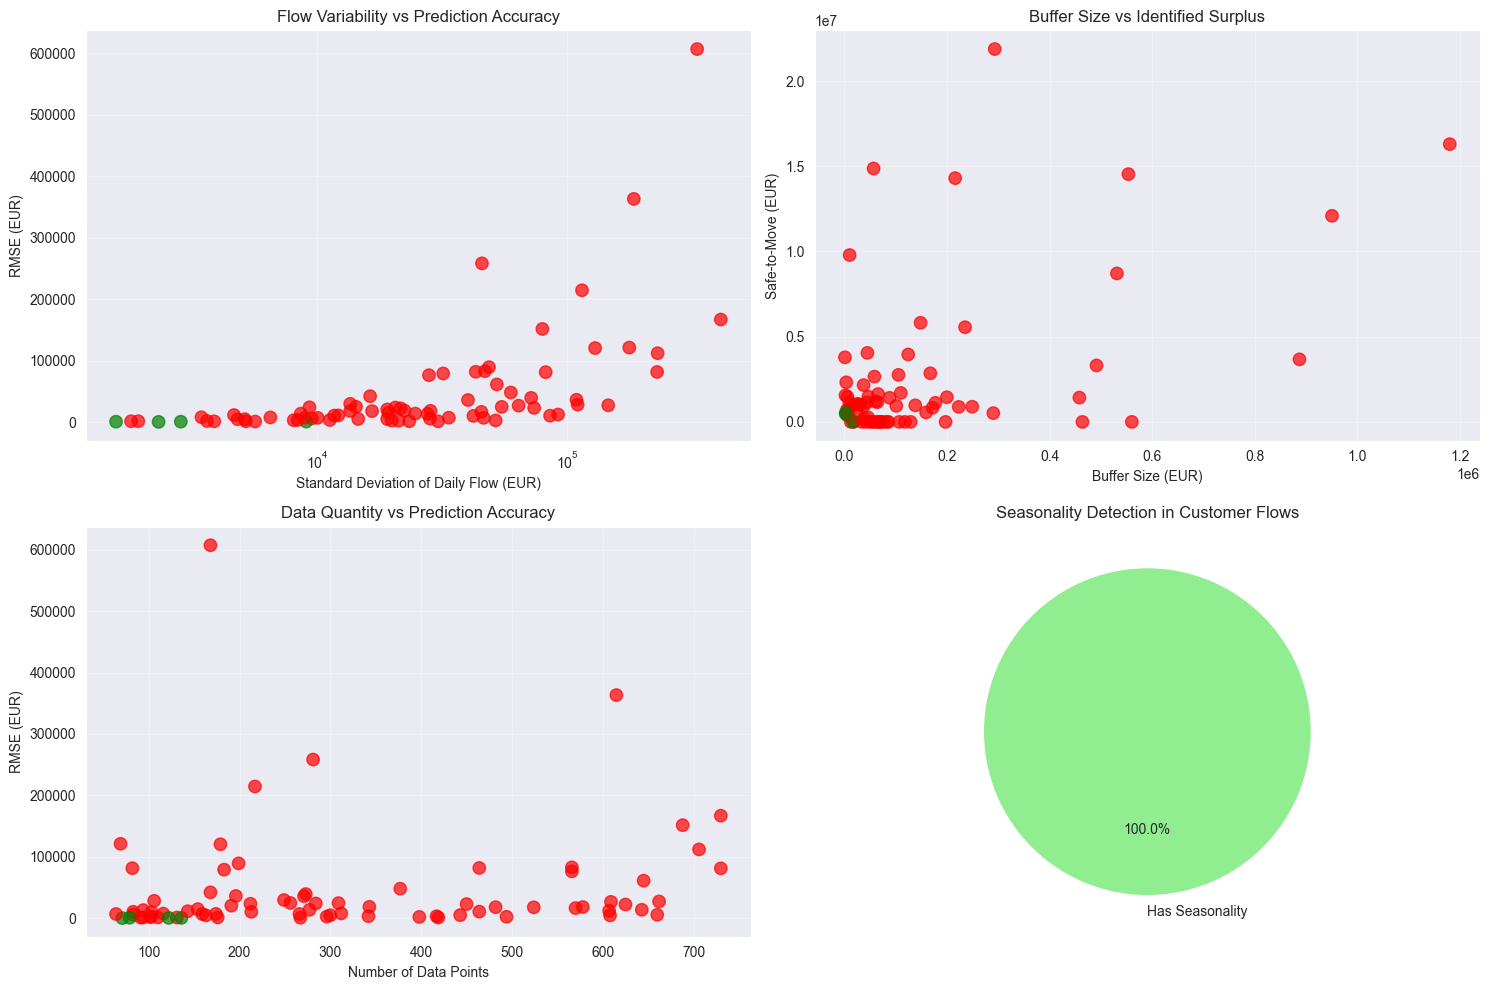

In [55]:
# ========================================
# 19. Additional Analysis
# ========================================

if len(results_corrected_grid) > 0:
    results_df = pd.DataFrame(results_corrected_grid)

    # Additional Analysis: Relationship between flow characteristics and predictability
    # Create a figure for additional insights
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Flow Variability vs RMSE
    axes[0,0].scatter(results_df['std_daily_flow'], results_df['rmse'],
                     c=results_df['meets_accuracy_target'].map({True:'green', False:'red'}),
                     alpha=0.7, s=80)
    axes[0,0].set_xlabel('Standard Deviation of Daily Flow (EUR)')
    axes[0,0].set_ylabel('RMSE (EUR)')
    axes[0,0].set_title('Flow Variability vs Prediction Accuracy')
    axes[0,0].grid(alpha=0.3)
    axes[0,0].set_xscale('log')

    # 2. Buffer Size vs Safe-to-Move
    axes[0,1].scatter(results_df['buffer'], results_df['total_safe_to_move'],
                     c=results_df['meets_accuracy_target'].map({True:'green', False:'red'}),
                     alpha=0.7, s=80)
    axes[0,1].set_xlabel('Buffer Size (EUR)')
    axes[0,1].set_ylabel('Safe-to-Move (EUR)')
    axes[0,1].set_title('Buffer Size vs Identified Surplus')
    axes[0,1].grid(alpha=0.3)

    # 3. Data Points vs RMSE
    axes[1,0].scatter(results_df['data_points'], results_df['rmse'],
                     c=results_df['meets_accuracy_target'].map({True:'green', False:'red'}),
                     alpha=0.7, s=80)
    axes[1,0].set_xlabel('Number of Data Points')
    axes[1,0].set_ylabel('RMSE (EUR)')
    axes[1,0].set_title('Data Quantity vs Prediction Accuracy')
    axes[1,0].grid(alpha=0.3)

    # 4. SARIMA Parameter Patterns - FIXED PIE CHART
    if 'sarima_params' in results_df.columns:
        # Extract seasonal component info
        seasonal_info = []
        for params in results_df['sarima_params']:
            if params and len(params) > 1:
                seasonal_order = params[1]
                seasonal_info.append({
                    'has_seasonality': seasonal_order[3] > 1,
                    'seasonal_period': seasonal_order[3]
                })

        if seasonal_info:
            seasonal_df = pd.DataFrame(seasonal_info)
            seasonal_counts = seasonal_df['has_seasonality'].value_counts()

            # Dynamic labels based on available categories
            labels = []
            colors = []
            sizes = []

            if True in seasonal_counts.index:
                labels.append('Has Seasonality')
                sizes.append(seasonal_counts[True])
                colors.append('lightgreen')

            if False in seasonal_counts.index:
                labels.append('No Seasonality')
                sizes.append(seasonal_counts[False])
                colors.append('lightcoral')

            if labels:  # Only create pie chart if we have data
                axes[1,1].pie(sizes, labels=labels, autopct='%1.1f%%',
                             colors=colors, startangle=90)
                axes[1,1].set_title('Seasonality Detection in Customer Flows')
            else:
                axes[1,1].text(0.5, 0.5, 'No seasonal data',
                              horizontalalignment='center', verticalalignment='center',
                              transform=axes[1,1].transAxes)
                axes[1,1].set_title('Seasonality Detection (No Data)')
        else:
            axes[1,1].text(0.5, 0.5, 'No seasonal parameters found',
                          horizontalalignment='center', verticalalignment='center',
                          transform=axes[1,1].transAxes)
            axes[1,1].set_title('Seasonality Detection (No Data)')
    else:
        axes[1,1].text(0.5, 0.5, 'SARIMA parameters not available',
                      horizontalalignment='center', verticalalignment='center',
                      transform=axes[1,1].transAxes)
        axes[1,1].set_title('Seasonality Detection (No Data)')

    plt.tight_layout()
    plt.show()